# Ezekiel Bonifacio


## Galaxy Classification using Neural Network Prototypes

## Required Libraries

In [1]:
import pandas as pd
import numpy as np

#display images
from IPython import display

#loading reduced dataset
import pickle as pkl

#saving models
import h5py

#Image data pre-processing
import cv2 

#data splitting
from sklearn.model_selection import train_test_split

#Model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

#Model creation/training/testing
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers

#Visualisation
from matplotlib import pyplot as plt

#to avoid fluctuations in outputs
from numpy.random import seed

seed(24)
tf.random.set_seed(24)

# 1.1 Business Question

A certain space agency is interested in the classification of galaxies. At the present moment, the most prominent classification method is done via human visual inspection (e.g. the <a href="https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/about/research"> Galaxy Zoo Project</a>). Due to the unfathomable amount of galaxies in the universe, the combined efforts of millions of eyes simply isn't cutting it, according to said space agency at least (**purely hypothetical**).

Because of this, they have employed me to **prototype some models until I can create one that can adequately classify images of galaxies into 10 prescribed classes**, as seen below.

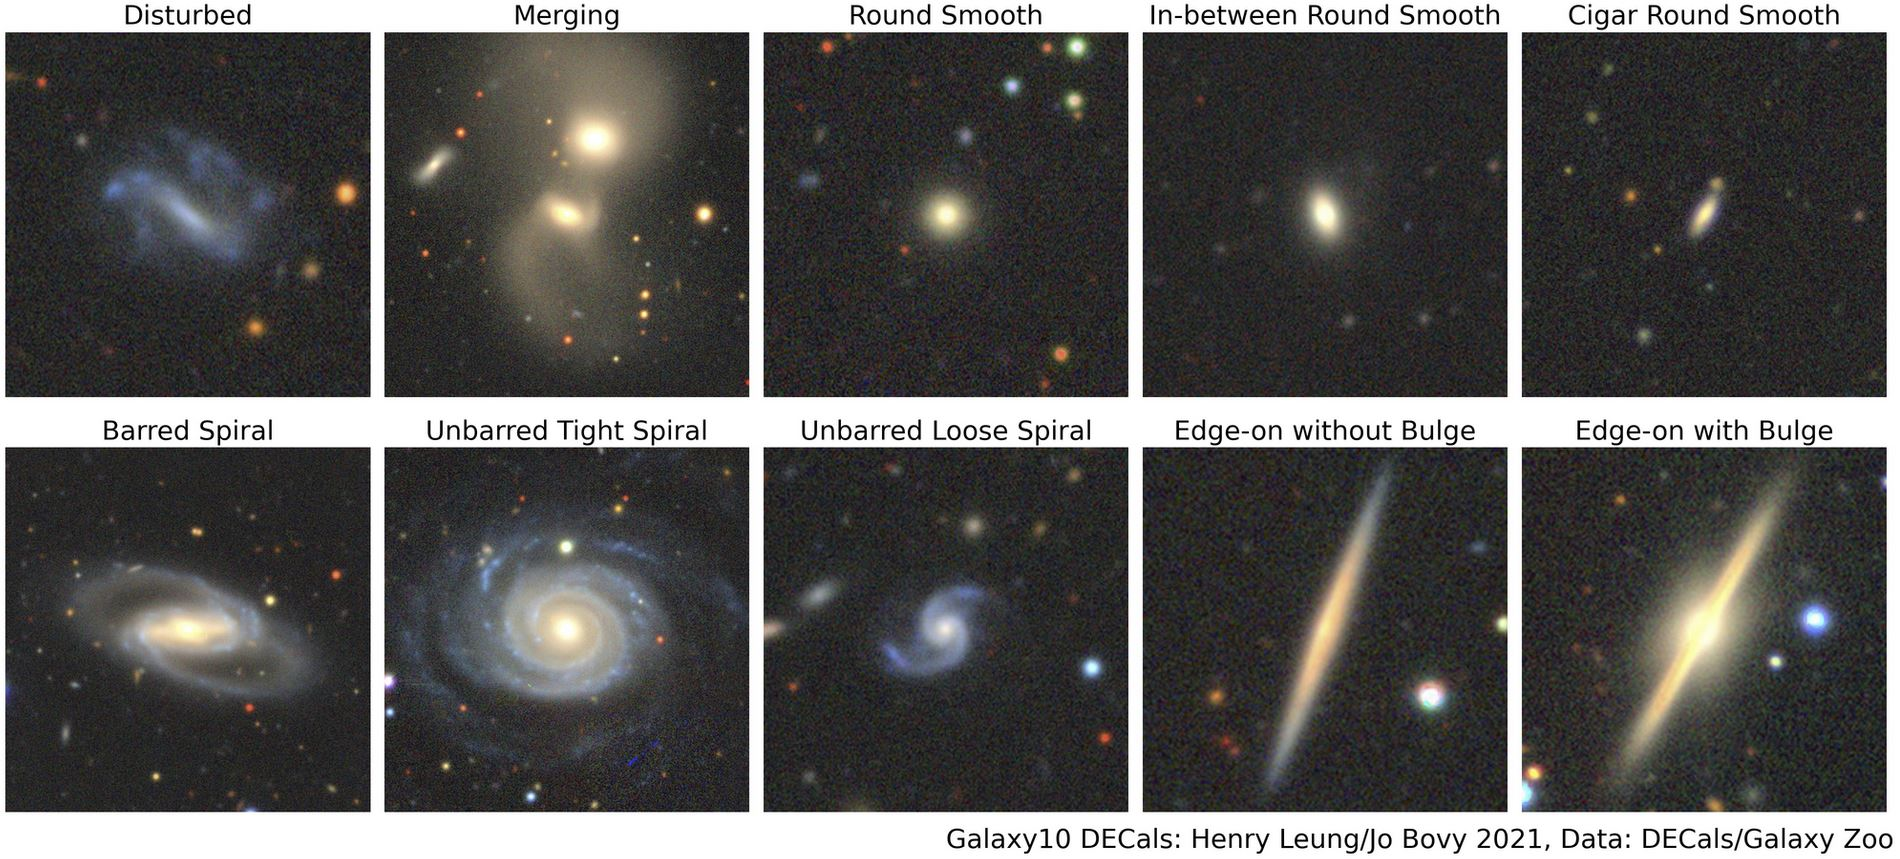

In [2]:
display.Image("Images/Galaxy_10_Classes.JPG")

### My interpretation

From this question/problem statement I can discern that I will have to create models for multi-class classification (as there are 10 classes). Based on the prescribed classes above, classification would be based on the shape features of the galaxies.

Before creating the model, I must first source my data. The most comprehensive galaxy image dataset is the <a href="https://astronn.readthedocs.io/en/latest/galaxy10.html"> Galaxy10 DECals dataset</a>. This dataset contains 17,736 coloured galaxy images (256x256 with g, r and z channels) separated in 10 classes. 


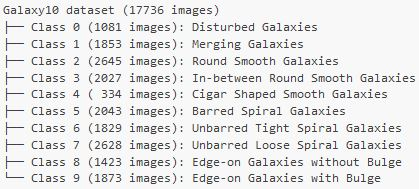

In [3]:
display.Image("Images/labels.JPG")

# 1.2 Data

As per the documentation instructions, the model will be loaded in using the h5py Python package. There will be an initial two variables, one containing the galaxy images, and one containing the classes as seen in the figures above.

### **Note. There will be a lot of commented code as the dataset was significantly reduced (would be 2.7GB otherwise). The commented code was used to pre-train the models such that they could have learned weights. As such, the models within this notebook will only be tested, as training has been done beforehand.**

In [4]:
# NEEDED FOR MODEL PRETRAINING, DO NOT RUN

# import h5py

# # To get the images and labels from file

# with h5py.File('Galaxy10_DECals.h5', 'r') as F:
#     images = np.array(F['images'])
#     labels = np.array(F['ans'])

#### Original Dataset (2.7GB preprocessing)

Additionally, some data pre-processing steps were conducted before the dataset was reduced.

First, visual inspection suggests that conversion of the images to grayscale would be of temporal and computational benefit.

Why?

Because the classification task at hand, based on the prescribed classes, are mainly **based on the galaxies' shape and NOT colour**. Due to this, it can be argued that colour information is not necessary to build an accurate model.

Additionally, grayscale conversion significantly reduces the dimensionality of the data.
  
Instead of having 256x256x3 (196,608) dimensions, the images will have 256x256x1 (65,536). This will reduce computational load during model training and testing, which in turn increases the model's temporal efficiency. 


To further decrease computational load, the images were also be resized, such that they are 128x128x1 instead of 256x256x1. Resizing this way may lead to poorer performance as information is lost, however the decrease in computational load may be more favourable than marginal performance increases.

### Image conversion to grayscale and resizing

To convert to grayscale, the below function was used. This function creates an empty list for storage, and afterwards loops through the images. For each iteration of the loop, the images are converted to grayscale and appended to the empty list previously created. The list is converted into a numpy array and is then returned. 

In [5]:
# ORIGINAL DATASET PRE-PROCESSING, DO NOT RUN

# def convert_to_grayscale(images):
#     # storage for converted images
#     gray = []
#     # loop through images
#     for i in range(len(images)):
#         # convert each image using openCV
#         gray.append(cv2.cvtColor(images[i,:], cv2.COLOR_BGR2GRAY))
#     # pack converted list as an array and return
#     return np.expand_dims(np.array(gray), axis = -1)

For resizing, the below function was used. It is straightforward enough, as it simply uses a built in function in tensorflow.

In [6]:
# ORIGINAL DATASET PRE-PROCESSING, DO NOT RUN

# def resize(images, new_size):
#     # use tensorflow built in resize function
#     return tf.image.resize(images, new_size).numpy()

The converted images were stored into a new **images_gray_resized** variable for clarity, and to preserve the original images variable.

In [7]:
# ORIGINAL DATASET PRE-PROCESSING, DO NOT RUN

# images_gray_resized = convert_to_grayscale(resize(images, (128, 128)))

# print(images_gray_resized.shape)

### Splitting the data into training, validation, and test sets

Now that the images and labels are in their preferred formats, they can be split into training, validation, and testing sets for the upcoming model to use. A 70/30 split was used for training/testing, with validation being half of testing. As such, the data distribution is 70/15/15 for training, validation, and testing respectively. 

In [8]:
# ORIGINAL DATASET PRE-PROCESSING, DO NOT RUN

# X_train, X_test, y_train, y_test = train_test_split(images_gray_resized, labels, test_size=0.3, random_state = 24)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state = 24)

### Image normalisation

Here normalisation was conducted such that instead of pixel values having a range of 0-255, they will have a range of 0-1. This is done by simply dividing the X variables by 255 (pixel values are 0 - 256, excluding zero would be 255). 

Normalisation should hopefully help with model convergence times when training the model.

In [9]:
# ORIGINAL DATASET PRE-PROCESSING, DO NOT RUN

# #normalise by dividing by 255
# X_train = X_train / 255
# X_val = X_val / 255
# X_test = X_test / 255

# #check that values range from 0-1 instead of 0-255
# print(X_train.min(), X_train.max())
# print(X_val.min(), X_val.max())
# print(X_test.min(), X_test.max())

### Dataset Reduction

The final preprocessing step involved data reduction. The dataset was reduced to 7095 total images, 40% of the original 17736. This was done to facilitate faster and smoother notebook runtime. Note however that the original dataset was still used to pre-train models, and they're architecture and weights will be used for testing with the reduced dataset.

Another caveat you might notice below is that the validation data has 1 extra sample over the test data. This is because the original train test split could not evenly split them (12415 train, 2661 val, 2660 test). This carries over to the reduced dataset as well.

In [10]:
# ORIGINAL DATASET PRE-PROCESSING, DO NOT RUN

# X_train_reduced = X_train[0:4966,:,:,:]
# y_train_reduced = y_train[0:4966]
# X_val_reduced = X_val[0:1065,:,:,:]
# y_val_reduced = y_val[0:1065]
# X_test_reduced = X_test[0:1064,:,:,:]
# y_test_reduced = y_test[0:1064:]

Finally, the train, val and test datasets were saved, so that they can be loaded in to this notebook. 

In [11]:
# ORIGINAL DATASET PRE-PROCESSING, DO NOT RUN

# #to save data
# with open("train.pkl", "wb") as f:
#     pkl.dump([X_train_reduced, y_train_reduced], f)

# with open("val.pkl", "wb") as f:
#     pkl.dump([X_val_reduced, y_val_reduced], f)

# with open("test.pkl", "wb") as f:
#     pkl.dump([X_test_reduced, y_test_reduced], f) 

All that is left to do now is to load the datasets.

In [12]:
#Loading in the reduced dataset
with open("datasets/train.pkl", "rb") as f:
    X_train, y_train = pkl.load(f)

with open("datasets/val.pkl", "rb") as f:
    X_val, y_val = pkl.load(f)

with open("datasets/test.pkl", "rb") as f:
    X_test, y_test = pkl.load(f)

In [13]:
X_train.shape, X_val.shape, X_test.shape

((4966, 128, 128, 1), (1065, 128, 128, 1), (1064, 128, 128, 1))

In [14]:
y_train.shape, y_val.shape, y_test.shape

((4966,), (1065,), (1064,))

### Dataset analysis

Although a lot of preliminary analysis was done with the original dataset, some key points will be highlighted here in the reduced dataset.

The first is that a major class imbalance exists for both the original and reduced dataset.

In [15]:
#convert to dataframe to use df functions
y_train_df = pd.DataFrame(y_train, columns=["Galaxy Type"])

#show number of data points in each class
y_train_df.value_counts()

Galaxy Type
7              753
2              717
5              570
3              569
1              544
9              533
6              513
8              391
0              291
4               85
dtype: int64

Above we can see that class 4 has significantly less samples than the other classes, having around 668 less than the majority class (class 7). This suggests that class imbalance exists in the data, and will have to be scrutinised. In the original dataset, this discrepancy was even more pronounced (334 samples for class 4, 2628 samples for class 7).

### Visual inspection of the image data

Now the characteristics of the images will be investigated. First, visual inspection was done by plotting the images using the below function.

This function first defines a plot using matplotlib.pyplot. It then iterates over the desired amount of images (in this case it was set to the first 50 images). For each image, a subplot was created so that the images can be displayed. 

In [16]:
#function to plot images
def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    
    #show 16 images
    for i in range(16):
        ax = fig.add_subplot(4, 4, i + 1)
        ax.imshow(x[i,:])
        ax.set_title(i)
        ax.axis('off')

Below was the output for the original dataset.

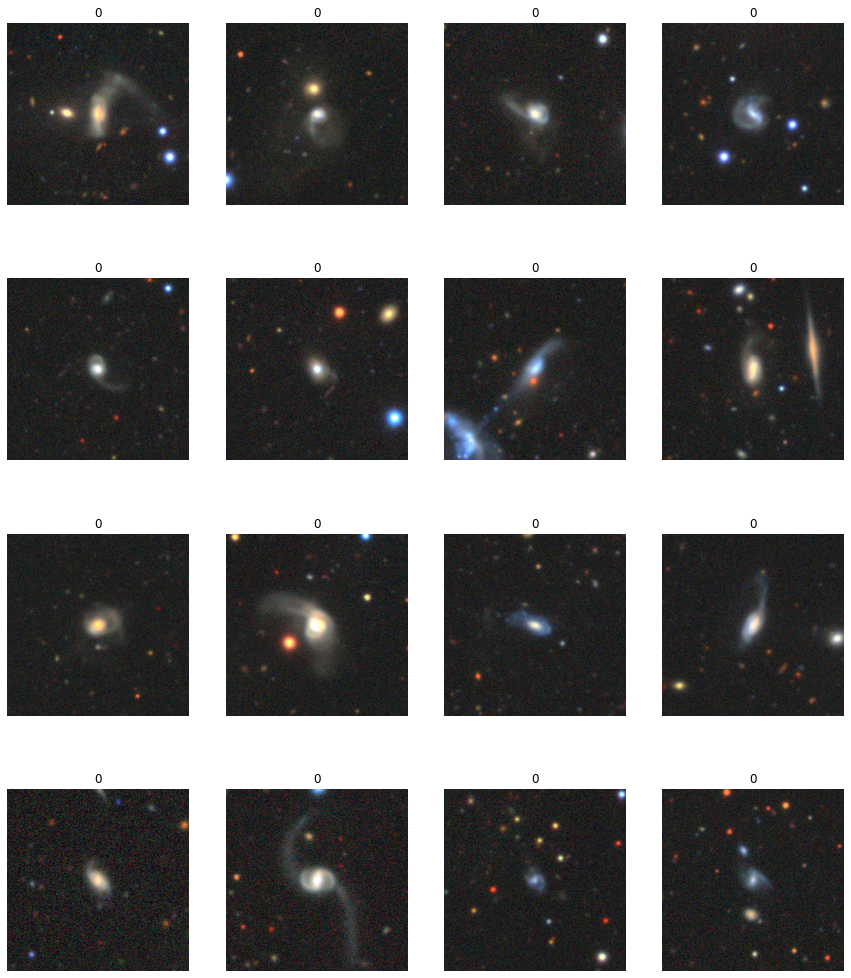

In [17]:
display.Image("Images/original_dataset_plot_image_output.png")

A few key factors to take note of here:

1. Image quality is not the best, although the downsizing might have amplified this
2. Large amount of pixel noise (fuzziness in the image)
3. Large amount of background noise (other intergalactic and interstellar objects in frame)
4. Class 0 is very difficult to classify visually (I personally would not group the top left-most image with the top right-most image).

The reduced dataset tells the same story.

These will have to be considered when discussing model performance and insights.

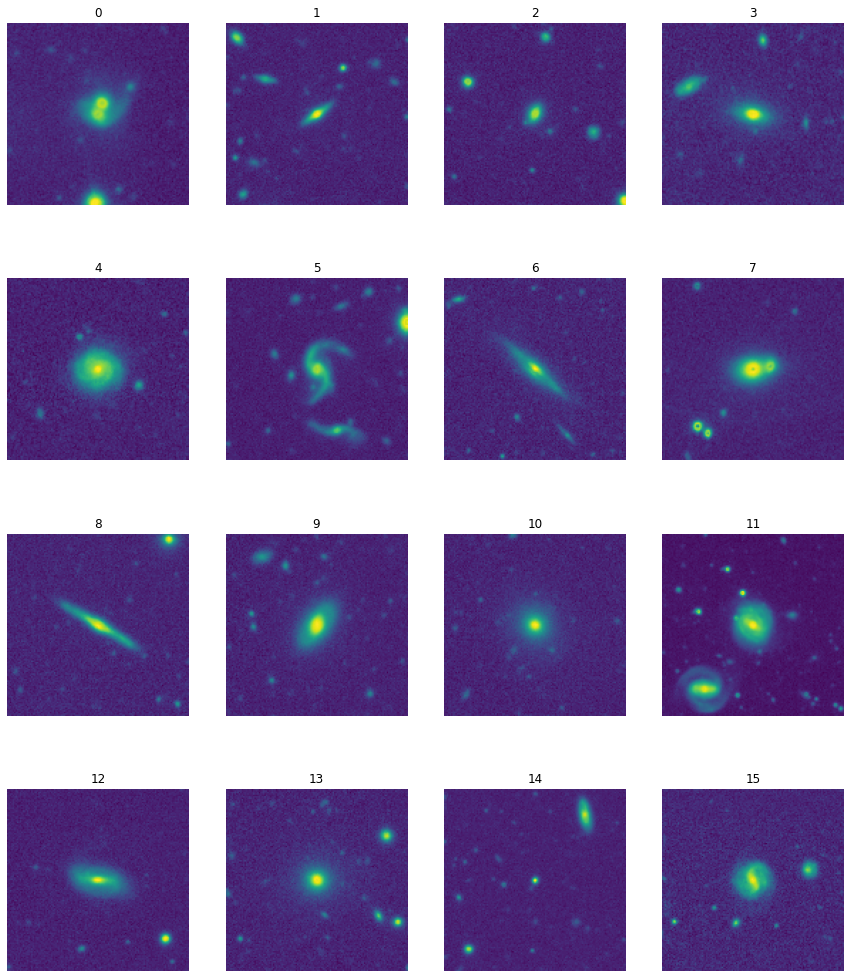

In [18]:
plot_images(X_train, y_train)

# 1.3 Analysis

### The model at hand

The model that will be used for this classification task is a neural network. This is because neural networks are known to perform well for multi-classification tasks.

### Vectorising for the basic NN model

So that the datasets are in an agreeable (and not frustrating) shape, the images will first be vectorised. This essentially changes the shape of the images to their product (128x128x1 shape turns into a shape of 16384).

This will be done through the function below that simply utilises numpy's reshape function. 

In [19]:
def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])

In [20]:
X_train_vector = vectorise(X_train)
X_val_vector = vectorise(X_val)
X_test_vector = vectorise(X_test)

In [21]:
#check shape
X_train_vector.shape, X_val_vector.shape, X_test_vector.shape

((4966, 16384), (1065, 16384), (1064, 16384))

### Model 1 Architecture (Basic NN)

I will first start with a basic, non-convolutional neural network with the following structure:

1. An input layer. This is where images will be sent through first.

2. 2 Dense layers. The first dense layer will output 32 dimensions, the second 16.
    - Each dense layer uses a ReLu activation. This activation was used as it is one of the more prominent activation functions in neural network literature.

3. An output layer. This layer will have 10 outputs corresponding to the 10 classes. 
    - This layer uses a softmax activation function. This function normalises the outputs into probabilities that sum to one.
        - This will therefore highlight the highest response, and suppress all others

In [22]:
# ORIGINAL DATASET MODEL CREATION, DO NOT RUN

# # this input layer is where images will be put through first
# inputs = keras.Input(shape=(16384,), name='relu')

# # First dense layer. This will receive the previous input layer's output and use it as it's own input
# x = layers.Dense(32, activation='relu')(inputs)

# # Second dense layer. this layer receives the output of the previous dense layer as it's input
# x = layers.Dense(16, activation='relu')(x)

# # Output layer. This layer has a length of 10 units corresponding to the 10 classes.
# outputs = layers.Dense(10, activation='softmax')(x)

# # create the model
# model_nn = keras.Model(inputs=inputs, outputs=outputs, name='galaxy_classification_nn')

# # Printing model summary
# model_nn.summary()

Model: "galaxy_classification_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 relu (InputLayer)           [(None, 16384)]           0         
                                                                 
 dense (Dense)               (None, 32)                524320    
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 10)                170       
                                                                 
Total params: 525,018
Trainable params: 525,018
Non-trainable params: 0
_________________________________________________________________


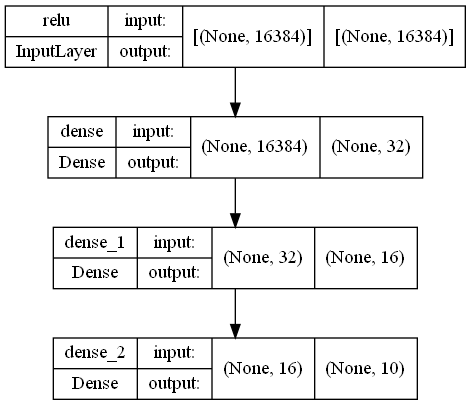

In [23]:
loaded_model_nn = tf.keras.models.load_model("model_nn")
loaded_model_nn.summary()
keras.utils.plot_model(loaded_model_nn, show_shapes=True)

From above, it can be seen that this model has around half a million trainable parameters. 

### Compiling the model

When compiling the model some key parameters should be noted:

1. **Sparse categorical cross-entropy** was used as the loss function. As this is a multi-class classification task, this would be the most appropriate function to use. Additionally, this will be the loss function that will accommodate the fact that one hot encoding was not done on the dataset. Categorical cross entropy would be the preferred function for OHE data, however it is a bit troublesome working with OHE data for visualisations which is why the data was left as is.

2. **Adam** was used as the optimiser. Studio and Workshop examples utilised the Nadam optimiser, however I am more familiar with Adam and as such it was implemented.

3. **Accuracy** was chosen as the performance metric. This was chosen to gauge the general performance of the model, however other metrics will be favoured when analysing model performance due to the previously found class imbalance.
    - **F1 scores, precision, and recall will be the most important performance measure due to the class imbalance**

In [24]:
# ALREADY COMPILED PRE-TRAINED MODEL, DO NOT RUN
# model_nn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#                   optimizer=keras.optimizers.Adam(),
#                   metrics=['accuracy'])

### Fitting the model

When fitting the model, another set of key parameters should be discussed:

1. **Batch size of 32**. This amount of samples per iteration was chosen to gauge the performance of the fairly basic nn model. 
2. **10 epochs**. This amount of iterations was chosen to again gauge basic nn model performance on the data.

Execution time will also be measured using the process_time() function from the time package.

In [25]:
# ALREADY FIT PRE-TRAINED MODEL, DO NOT RUN

# # package to measure execution time
# from time import process_time

# fitting_start = process_time()

# history = model_nn.fit(X_train_vector, y_train,
#                         batch_size=32,
#                         epochs=10,
#                         validation_data=(X_val_vector, y_val))

# fitting_end = process_time()

# print('Time to fit data:   %f seconds' % (fitting_end - fitting_start))

For reference, the pre-trained model took 22.42 seconds to train and went through all 10 iterations.

# 1.4 Model Performance and Visualisations

To evalute model performance, I have created a function below that will print test loss and accuracy, while also creating a classification report and confusion matrix. 

The classification report will be used to evlaute the model on different metrics such as Precision, Recall, and F1 scores.

The confusion matrix will be used to visualise relative classification accuracy for each class.

In [26]:
# function for evaluating model
def evaluate_model(model, x_test, y_test):
    
    # print test loss and accuracy
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    # data to be fed through confusion matrix and classification report
    pred = model.predict(x_test)
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)
    
    # create confusion matrix
    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

    # print classification report
    print(classification_report(y_test, indexes))

The below code will evaluate the model on the test set and print training and testing accuracy.

In [27]:
# evaluate the model
# evaluate the model
_, train_acc = loaded_model_nn.evaluate(X_train_vector, y_train, verbose=1)
_, test_acc = loaded_model_nn.evaluate(X_test_vector, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

34/34 [==============================] - 0s 2ms/step - loss: 2.2286 - accuracy: 0.1598
Train: 0.152, Test: 0.160


34/34 - 0s - loss: 2.2286 - accuracy: 0.1598 - 75ms/epoch - 2ms/step
Test loss: 2.228623867034912
Test accuracy: 0.15977443754673004


C:\Users\mulaw\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mulaw\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mulaw\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.00      0.00      0.00       112
           2       0.00      0.00      0.00       155
           3       0.00      0.00      0.00       127
           4       0.00      0.00      0.00        28
           5       0.00      0.00      0.00       111
           6       0.00      0.00      0.00       105
           7       0.16      1.00      0.28       170
           8       0.00      0.00      0.00        86
           9       0.00      0.00      0.00       108

    accuracy                           0.16      1064
   macro avg       0.02      0.10      0.03      1064
weighted avg       0.03      0.16      0.04      1064



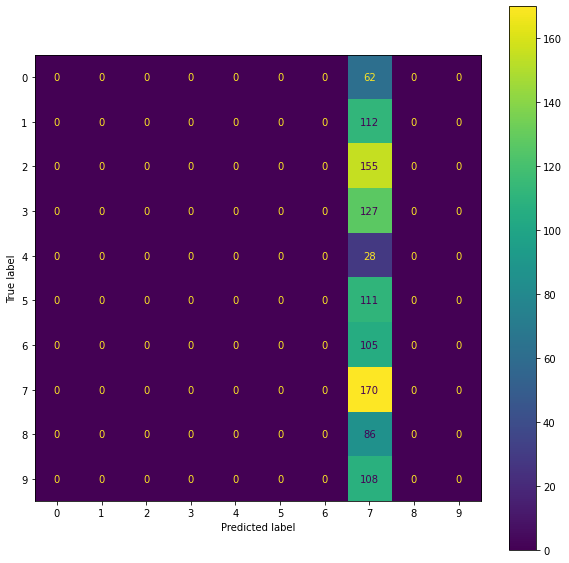

In [28]:
evaluate_model(loaded_model_nn, X_test_vector, y_test)

### Classification Report Analysis

From the classification report, we can discern that class 7 is the only class with performance metrics above 0.

The network is failing to learn from the training set.

### Confusion Matrix Analysis

From the confusion matrix:

Class 7 is the only class with classifications.

Learning failure may be due to the shallowness of the model
- It isn't deep/complex enough to capture the required abstractions to formulate correct classifications

### Accuracy and loss graphs

Saving and loading history was proving difficult to debug, as such here I will just be displaying the images of the output from the original dataset training. 

In [29]:
# HISTORY WASN'T SAVED, FOR CLARIFICATION PURPOSES ONLY

# plot accuracy
# plt.plot(model_nn_history.history['accuracy'], label='train')
# plt.plot(model_nn_history.history['val_accuracy'], label='val')
# plt.ylabel('accuracy', fontsize=12)
# plt.xlabel('iterations', fontsize=12)
# plt.legend()
# plt.show()

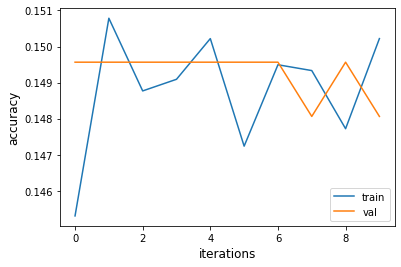

In [30]:
display.Image("Images/nn_history_accuracy.png")

In [31]:
# # plot validation loss
# plt.plot(model_nn_history.history['loss'], label='train')
# plt.plot(model_nn_history.history['val_loss'], label='val')
# plt.ylabel('loss', fontsize=12)
# plt.xlabel('iterations', fontsize=12)
# plt.legend()
# plt.show()

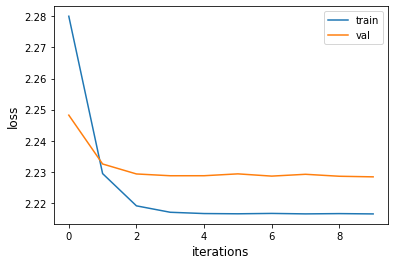

In [32]:
display.Image("Images/nn_history_loss.png")

From the above graphs we can see that the model is struggling to learn. Perhaps the network architecture is simply not deep enough to extract enough detail from the images to be able to classify them appropriately. 

### Evaluation Summary

From the evaluations above, we can see that it performed abysmally. It would seem that the model found it difficult to learn from the training set.

Fitting time was relatively quick, however the terrible performance makes this metric uninterpretable too. 

What could have caused such abysmal performance?

A few factors to be considered.

1. **NN shallowness**. The neural network only consisted of an input, an output, with dense layers in between. Perhaps a deeper network would perform better.

2. **Layer characteristics**.
    - Number of outputs for the dense layers could have been too low.
    - Suboptimal activation functions chosen (perhaps use tanh and sigmoid?)
3. **compiling parameters**.
    - A batch size of 32 might be too small.
    - Note that the number of epochs would not matter in this context as increasing it to say 100 would not meaningfully change performance (accuracy and loss never change significantly)

4. **data type**. Although the data was flattened through vectorisation, perhaps the use of a convolutional neural network which is better suited for image data would be best?


### Improving the model

When considering the performance factors previously discussed, I think the most important contributor to better performance would be to deepen the neural network's complexity by using convolutional filters, as well as MaxPooling layers.

Convolutional layers are essentially filters that perform a weighted sum of an input. 
- These are important for detecting abstractions/features (edges, corners etc.)

MaxPooling layers essentially take the maximum value in a region as output. Pooling layers aggregate features and therefore reduce dimensionality of the image data.
- This will be important as models become deeper and more complex.

With these in mind, the following model will have a structure of:

1. An input layer. Instead of a vectorised input, it will take the grayscaled images (128 x 128 x 1)
2. 2 Convolutional layers. 
    - The first will have 8 filters, the second 16, and the third 32. All filters are 3x3 in size.
    - The filters are doubling every convolutional layer. This was done as more filters equates to a higher number of abstractions that the network will be able to extract. 
        - Low filter amount in the beginning to capture simple patterns, greater filter amounts the deeper the network to learn more complex patterns
3. A MaxPooling layer after every convolutional layer.
    - These will be 2x2 in size.
4. A flatten layer after the last convolution layer.
    - This layer will turn the network into a 1D shape to be passed into the last dense (fully connected) layer.
5. An output layer with 10 units, for the 10 classes.
    - softmax activation for normalisation. 


In [33]:
# MODEL PRE-TRAINED, DO NOT RUN

# # this input layer is where images will be put through first
# inputs = keras.Input(shape=(128, 128, 1, ), name='img')

# # this convolutional layer will take in the output from the input layer as it's input
# x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)

# # 2x2 max pooling, this will downsample the image by a factor of 2
# x = layers.MaxPool2D(pool_size=(2, 2))(x)

# # Second convolutional filter with double the filters as the previous
# x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)

# x = layers.MaxPool2D(pool_size=(2, 2))(x)

# # third convolution, 32 filters
# x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)

# # a flatten layer to turn network state into 1D shape to pass into fully connected layer
# x = layers.Flatten()(x)

# # fully connected layer, 64 inputs
# x = layers.Dense(256, activation='relu')(x)

# # Output layer, where 10 is the number of outputs corresponding to the 10 classes.
# # Softmax activation normalises the output
# outputs = layers.Dense(10, activation='softmax')(x)

# # Building the model
# model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='galaxy_classification_cnn')

# # Printing model summary
# model_cnn.summary()

Model: "galaxy_classification_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 2

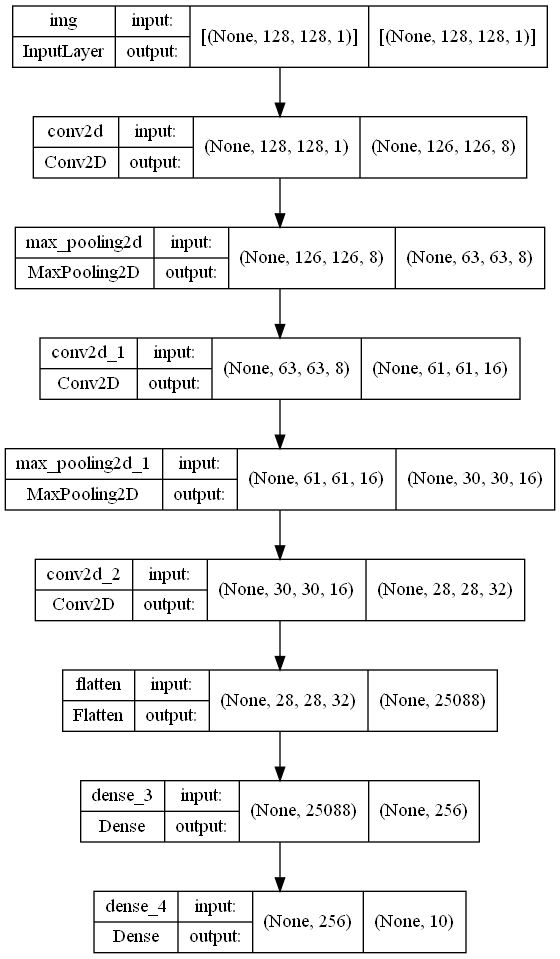

In [34]:
loaded_model_cnn = tf.keras.models.load_model("model_cnn")
loaded_model_cnn.summary()
keras.utils.plot_model(loaded_model_cnn, show_shapes=True)

### Compiling Parameters

Kept the same as the previous model.

In [35]:
# DO NOT RUN

# model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#                   optimizer=keras.optimizers.Adam(),
#                   metrics=['accuracy'])

### Fitting parameters

Batch size was increased to 128 and number of epochs was increased to 100. Greater number of epochs will let the model train for longer, and greater batch size means more samples will be propagated through the network per epoch. 

### EarlyStopping

Note that for fitting the current model and future models, **EarlyStopping** has been implemented. This keras function simply allows the model to stop training based on a parameter, which in this case will be validation loss to monitor overfitting.
- A patience of 10 means that the model will stop training when validation loss has either stayed the same or increased (which suggests overfitting) after 8 successive epochs.

This function was implemented as the model is now far deeper and more complex than the previous one, with over 6 million parameters. Overfitting is likely to occur in this sense, as the model might train on the noise of the image data in the training set.

As such, this function will stop training to save time; if the model overfits over 10 iterations, chances are it will overfit over n iterations afterwards too. 

In [36]:
# DO NOT RUN

# #early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1),

# fitting_start = process_time()

# model_cnn_history = model_cnn.fit(X_train, y_train,
#                         batch_size=128,
#                         epochs=100,
#                         validation_data=(X_val, y_val),
#                         callbacks=early_stopping)

# fitting_end = process_time()

# print('Time to fit data:   %f seconds' % (fitting_end - fitting_start))

For reference, the model took 32.22 seconds to train and reached the 14th epoch before early stopping.

In [37]:
# evaluate the model
# evaluate the model
_, train_acc = loaded_model_cnn.evaluate(X_train, y_train, verbose=1)
_, test_acc = loaded_model_cnn.evaluate(X_test, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

34/34 [==============================] - 0s 4ms/step - loss: 2.5985 - accuracy: 0.5291
Train: 0.993, Test: 0.529


This model definitely performed better than the previous one. Testing accuracy is still very low which is a definite concern. 

34/34 - 0s - loss: 2.5985 - accuracy: 0.5291 - 100ms/epoch - 3ms/step
Test loss: 2.5984644889831543
Test accuracy: 0.5291353464126587
              precision    recall  f1-score   support

           0       0.12      0.10      0.11        62
           1       0.53      0.62      0.57       112
           2       0.80      0.65      0.71       155
           3       0.62      0.61      0.61       127
           4       0.33      0.18      0.23        28
           5       0.37      0.48      0.42       111
           6       0.44      0.38      0.41       105
           7       0.43      0.41      0.42       170
           8       0.70      0.81      0.75        86
           9       0.59      0.68      0.63       108

    accuracy                           0.53      1064
   macro avg       0.49      0.49      0.49      1064
weighted avg       0.53      0.53      0.53      1064



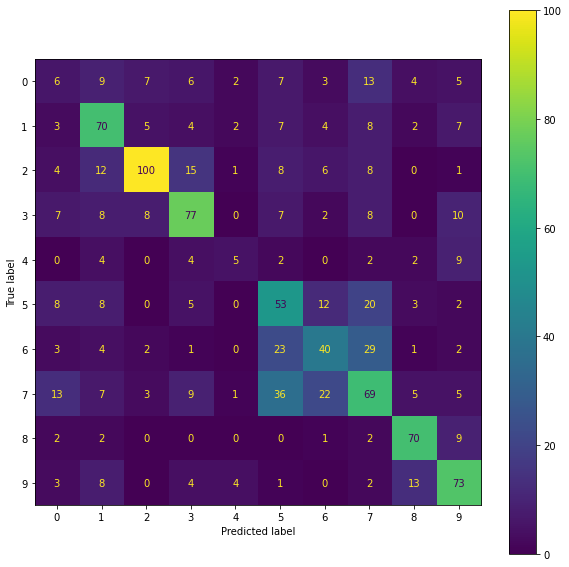

In [38]:
evaluate_model(loaded_model_cnn, X_test, y_test)

### Classification Report Analysis  

**Note here that the exact classification report values for all models onwards will be subject to change if rerunning the code due to random factors. The hard values mentioned in the analysis were the values seen after runtime**.

From the Classification report we can see:
1. Lowest performance metrics (Precision, Recall, and F1 scores) for class 0 and class 4. 
    - Out of all the positively predicted classifications, only 12% were truly positive for class 0. (precision)
    - Only 10% of all ground truth positives were correctly classified as class 0 (recall)
2. Highest performance metrics for class 2.
    - Out of all the positively predicted classifications, 80% were truly positive for class 2 (precision)
    - 65% of all ground truth positives were correctly classified as class 0 (recall)

These results suggest that the class imbalance is affecting model performance.

3. Model accuracy is 53% which is quite low, however the model is still achieving somewhat decent performance for certain classes
- This is evident from performance metrics. Specifically, F1 scores for class 2 and 8.
4. With macro-average as an alternative measure to overall accuracy, we can see it is around 49% which is not ideal.

### Confusion Matrix Analysis

From the Confusion Matrix, we can see:

1. Low number of correct classifications for class 0 and 4, in line with classification report
2. Highest number of correct classifications for class 2, followed by class 9 (subject to change if rerunning code).

### Accuracy and Loss Graphs

In [39]:
# # plot accuracy
# plt.plot(model_cnn_history.history['accuracy'], label='train')
# plt.plot(model_cnn_history.history['val_accuracy'], label='val')
# plt.ylabel('accuracy', fontsize=12)
# plt.xlabel('iterations', fontsize=12)
# plt.legend()
# plt.show()

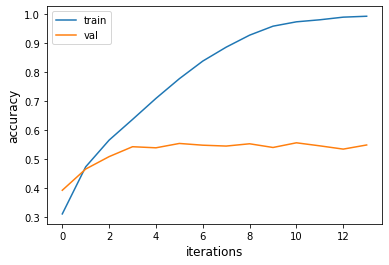

In [40]:
display.Image("Images/cnn_hist_acc.png")

The above graph definitely shows signs of overfitting. This is evident from the testing accuracy reaching almost 100% while validation accuracy is not improving significantly.

In [41]:
# # plot validation loss
# plt.plot(model_cnn_history.history['loss'], label='train')
# plt.plot(model_cnn_history.history['val_loss'], label='val')
# plt.ylabel('loss', fontsize=12)
# plt.xlabel('iterations', fontsize=12)
# plt.legend()
# plt.show()

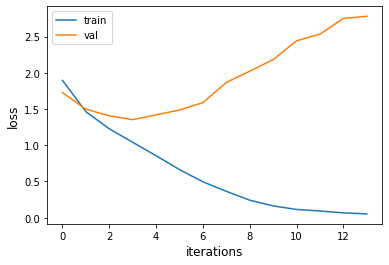

In [42]:
display.Image("Images/cnn_hist_loss.png")

Additionally, it is also evident from the ever increasing validation loss and near or at 0 training loss.

### 2nd Model Summary

From the evaluations we can see that the 2nd model has less than favourable accuracy, however a closer look at other performance metrics with class imbalance in mind has shown that the model can predict 2 classes relatively well. This does however come at the cost of classification performance for the 2 classes with the least amount of samples. For now, I will still leave class imbalance unaddressed, as I want to see if accounting for overfitting will increase model performance.

The second model definitely performed better than the first, as it actually learned something. However, it may have learned the training set **TOO** well. As such, the model has definitely overfit, and this will have to be addressed. 

The reasons for this overfitting could be:

1. The amount of model parameters. The current model has over 6 million. This makes it extremely susceptible to learning the noise within the images in the training data, and thus limiting the model's ability to generalise to the validation data.
2. Limited data. While we do have 1000-2000 samples per class, there is still class 4 with around 300. This class imbalance may be affecting model generalisability.

Before addressing the class imbalance, methods to account for overfitting will first be implemented.

### Accounting for overfitting

Some methods to address overfitting are penalties(regularisation), dropout, spatial dropout and batch normalisation:

- **Regularisation** adds a penalty term that affects the network's weights. L1 regularisation affects it such that the weights can be reduced to zero, while L2 lets weights get close to, but never reach 0. 

- **Dropout** essentially sets a percentage of neurons to zero (50% if you are using Dropout(0.5) for example). This means that not all neurons in hidden layers activate, and thus prevents overfitting.

- **Spatial Dropout** works much in the same way as Dropout, except instead of affecting neurons in dense layers, it operates over convolutional filters and drops all neurons in a specified percentage of filters. 

- **Batch normalisation** essentially normalises activations at certain points in the network. As such, a BatchNorm layer will transform the data into a shape that is easier to learn (by using the mean and standard deviations of the activations).

To hopefully and drastically improve the model, all four will be implemented.



### The third model

The structure is as follows:

1. Input and output layers remain the same.
2. In between the input and output layers, there will be four convolutional 'blocks'. Each block consists of:
    - 2 convolutional filters, both doubling in size after each successive block (8, 16, 32, 64, 128).
    - Note that the number of filters per convolutional layer was reduced. This is to minimise the amount of parameters (and thus somewhat counteract overfitting). This allows the model to be deeper, while keeping the parameter amount at bay.
        - Each filter will have padding as set to same.
        - Each filter will have L2 regularisation. L2 is favoured over L1 as the latter might make it too difficult for the model to learn.
            - Padding is essentially accounting for when the filters are going over the borders of an image. When they do, they will not be able to capture all data (as the image ends at a certain point.)
    - A Spatial Dropout layer that will drop all neurons for 20% of the filters
    - A Max Pooling layer of size 2x2 to reduce dimensionality
3. The last convolutional block will have a flatten layer instead of a Max Pool layer to feed the data through 2 fully connected dense layers that are 512 in size.
    - the fully connected layers will also be regularised with L2 regularisation.
4. Before the output layer, a Dropout layer that will set half of the neurons to 0. 

In [43]:
# DO NOT RUN

# inputs = keras.Input(shape=(128, 128, 1, ), name='img')

# # Convolutional Block 1 ---------------------------------------------------------------------------------------------
# x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l2')(inputs)
# x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l2')(x)

# x = layers.SpatialDropout2D(0.2)(x)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPool2D(pool_size=(2, 2))(x)

# # Convolutional Block 2 ---------------------------------------------------------------------------------------------
# x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l2')(x)
# x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l2')(x)

# x = layers.SpatialDropout2D(0.2)(x)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPool2D(pool_size=(2, 2))(x)

# # Convolutional Block 3 ---------------------------------------------------------------------------------------------
# x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l2')(x)
# x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l2')(x)

# x = layers.SpatialDropout2D(0.2)(x)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPool2D(pool_size=(2, 2))(x)

# # Convolutional Block 4 ---------------------------------------------------------------------------------------------
# x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l2')(x)
# x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l2')(x)

# x = layers.SpatialDropout2D(0.2)(x)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPool2D(pool_size=(2, 2))(x)

# # Convolutional Block 5 ---------------------------------------------------------------------------------------------
# x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l2')(x)
# x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer='l2')(x)

# x = layers.SpatialDropout2D(0.2)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Flatten()(x)

# # Fully Connected Block ---------------------------------------------------------------------------------------------
# x = layers.Dense(512, activation='relu', kernel_regularizer='l2')(x)
# x = layers.Dense(512, activation='relu', kernel_regularizer='l2')(x)

# x = layers.Dropout(0.5)(x)

# outputs = layers.Dense(10, activation='softmax')(x)

# # Building the model (afo stands for accounting for overfitting)
# model_cnn_afo = keras.Model(inputs=inputs, outputs=outputs, name='galaxy_classification_cnn_AFO')

# # Printing model summary
# model_cnn_afo.summary()


Now to load the pretrained model.

Model: "galaxy_classification_cnn_AFO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 8)       80        
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 8)       584       
                                                                 
 spatial_dropout2d (SpatialD  (None, 128, 128, 8)      0         
 ropout2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 

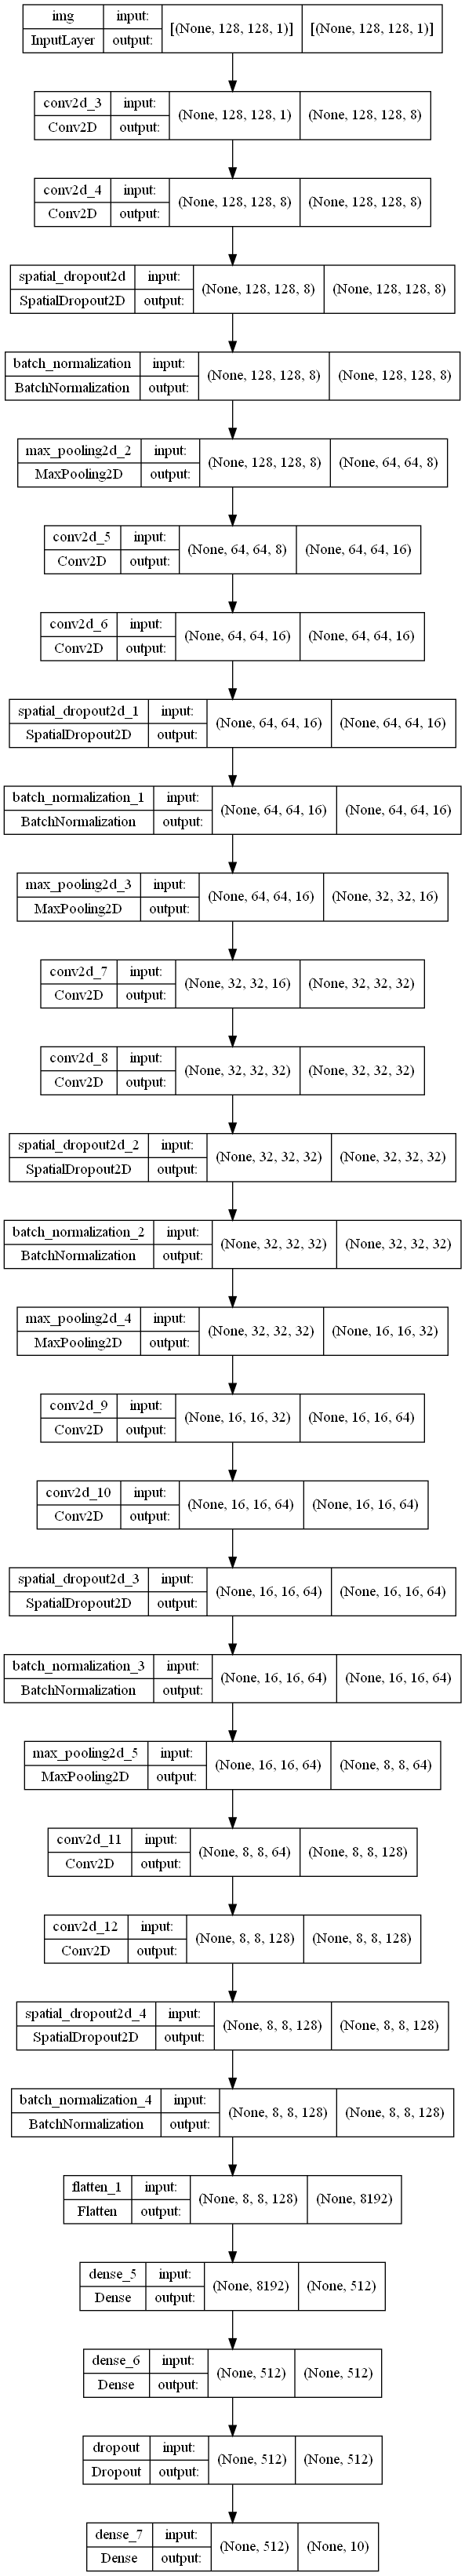

In [44]:
loaded_model_cnn_afo = tf.keras.models.load_model("model_cnn_afo")
loaded_model_cnn_afo.summary()
keras.utils.plot_model(loaded_model_cnn_afo, show_shapes=True)

### Compiling and Fitting Parameters

Again these will stay the same.

In [45]:
# DO NOT RUN
# model_cnn_afo.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#                   optimizer=keras.optimizers.Adam(),
#                   metrics=['accuracy'])

In [46]:
# #early stopping params
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# fitting_start = process_time()

# model_cnn_afo_history = model_cnn_afo.fit(X_train, y_train,
#                         batch_size = 128,
#                         epochs=100,
#                         validation_data=(X_val, y_val),
#                         callbacks=early_stopping)

# fitting_end = process_time()

# print('Time to fit data:   %f seconds' % (fitting_end - fitting_start))

For reference this model took 241.1 seconds to train, and reached the 45th epoch before early stopping.

In [47]:
# evaluate the model 
_, train_acc = loaded_model_cnn_afo.evaluate(X_train, y_train, verbose=1)
_, test_acc = loaded_model_cnn_afo.evaluate(X_test, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

34/34 [==============================] - 0s 8ms/step - loss: 1.3214 - accuracy: 0.6889
Train: 0.785, Test: 0.689


34/34 - 0s - loss: 1.3214 - accuracy: 0.6889 - 155ms/epoch - 5ms/step
Test loss: 1.3214267492294312
Test accuracy: 0.6889097690582275
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.67      0.62      0.64       112
           2       0.89      0.86      0.88       155
           3       0.82      0.91      0.86       127
           4       0.62      0.29      0.39        28
           5       0.51      0.84      0.63       111
           6       0.61      0.70      0.65       105
           7       0.54      0.42      0.47       170
           8       0.78      0.90      0.83        86
           9       0.77      0.85      0.81       108

    accuracy                           0.69      1064
   macro avg       0.62      0.64      0.62      1064
weighted avg       0.65      0.69      0.66      1064



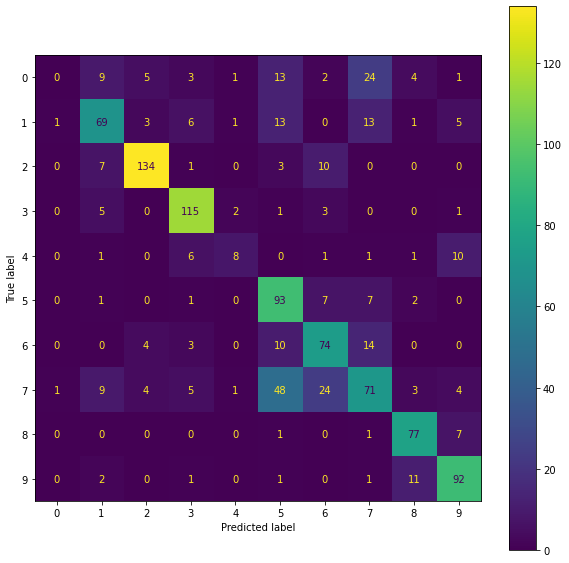

In [48]:
evaluate_model(loaded_model_cnn_afo, X_test, y_test)

### Classification Report Analysis

The model is still struggling to classify the minority classes, evident from their poor performance metrics.
- Class 0 is surprising as it has lower classifications than class 4, which has the least samples. 

Class 0
- None of all positively predicted classifications were truly positive (precision)
- None of all ground truth positives were correctly classified as class 0 (recall)

Class 4
- 62% of all positively predicted classifications were truly positive (precision)
- 29% of all ground truth positives were correctly classified as class 4 (recall)

Class 2
- 89% of all positively predicted classifications were truly positive (precision)
- 86% of all ground truth positives were correctly classified as class 2 (recall)

Class 3
- 82% of all positively predicted classifications were truly positive (precision)
- 91% of all ground truth positives were correctly classified as class 3 (recall)

F1 scores have improved overall (macro average from .49 in previous model to .62)

### Confusion Matrix Analysis

1. Class 2 and class 3 have the most correct classifications (may change due to random factors)
2. Class 0 and Class 4 have the least, with class 0 having none.

### Accuracy and Loss graphs

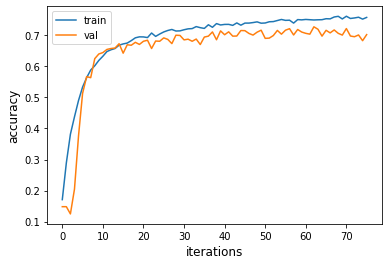

In [49]:
display.Image("Images/cnn_afo_hist_acc.png")

Model seems to be converging, which is an improvement from before.

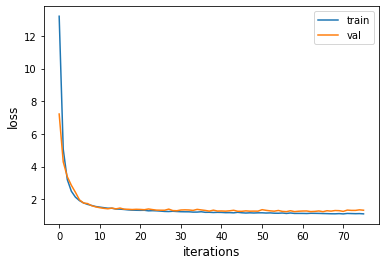

In [50]:
display.Image("Images/cnn_afo_hist_loss.png")

There is minute evidence of overfitting in the loss graph.

### 3rd Model Summary

By accounting for overfitting and creating an even deeper convolutional network, accuracy increased from around 50% to ~70% and macro average from ~50% to ~60%. A closer look at other performance metrics has shown that overall model performance has increased, however the class imbalance is still negatively affecting classification performance for the minority classes.

Note however that class 0 seems to be underperforming, even compared to class 4.

To see if the model can perform any better, a few key factors will be addressed.

1. Class imbalance. This issue was not a priority initially as I wanted to see how well the models would perform without strictly addressing it. Now, it is definitely going to be addressed.
2. Image noise. Another limiting factor could be the quality of the images. 
- Note that the original images were 256x256x3. Now they are 128x128x1. 
- Reducing the pixel size of the images may have magnified the impact of noise (as previously mentioned: fuzziness and blur due to atmospheric disturbances or camera focus, intergalactic matter obscuring the view, and multiple intergalactic objects)

Image noise from fuzziness, blur and camera focus can definitely addressed using astrophotography techniques, however that is outside the scope of the assignment.
I will be using data augmentation and class weights to address these instead.

### Addressing Noise with data augmentation

A method that can be used to alleviate the affects of these two factors is data augmentation.

Essentially, data augmentation allows for slight alterations of the original images, such that they still the same images yet altered in a certain dimensionality.
- By this I mean images could be flipped, slightly rotated left or right, slightly zoomed in etc.
- This can help improve the generalisability of the model by artificially increasing variation in the data.

For this, I will create a data_augmentation variable that will have the alterations that will be implemented. As a safety measure, I will visualise what these alterations do to the images to make sure that they don't alter the ground truth (cropping a galaxy's tail will make it difficult to classify for example). The data augmentation will:
- Randomly flip the images horizontally
- Randomly rotate the images by a certain degree
- Randomly zoom in on images

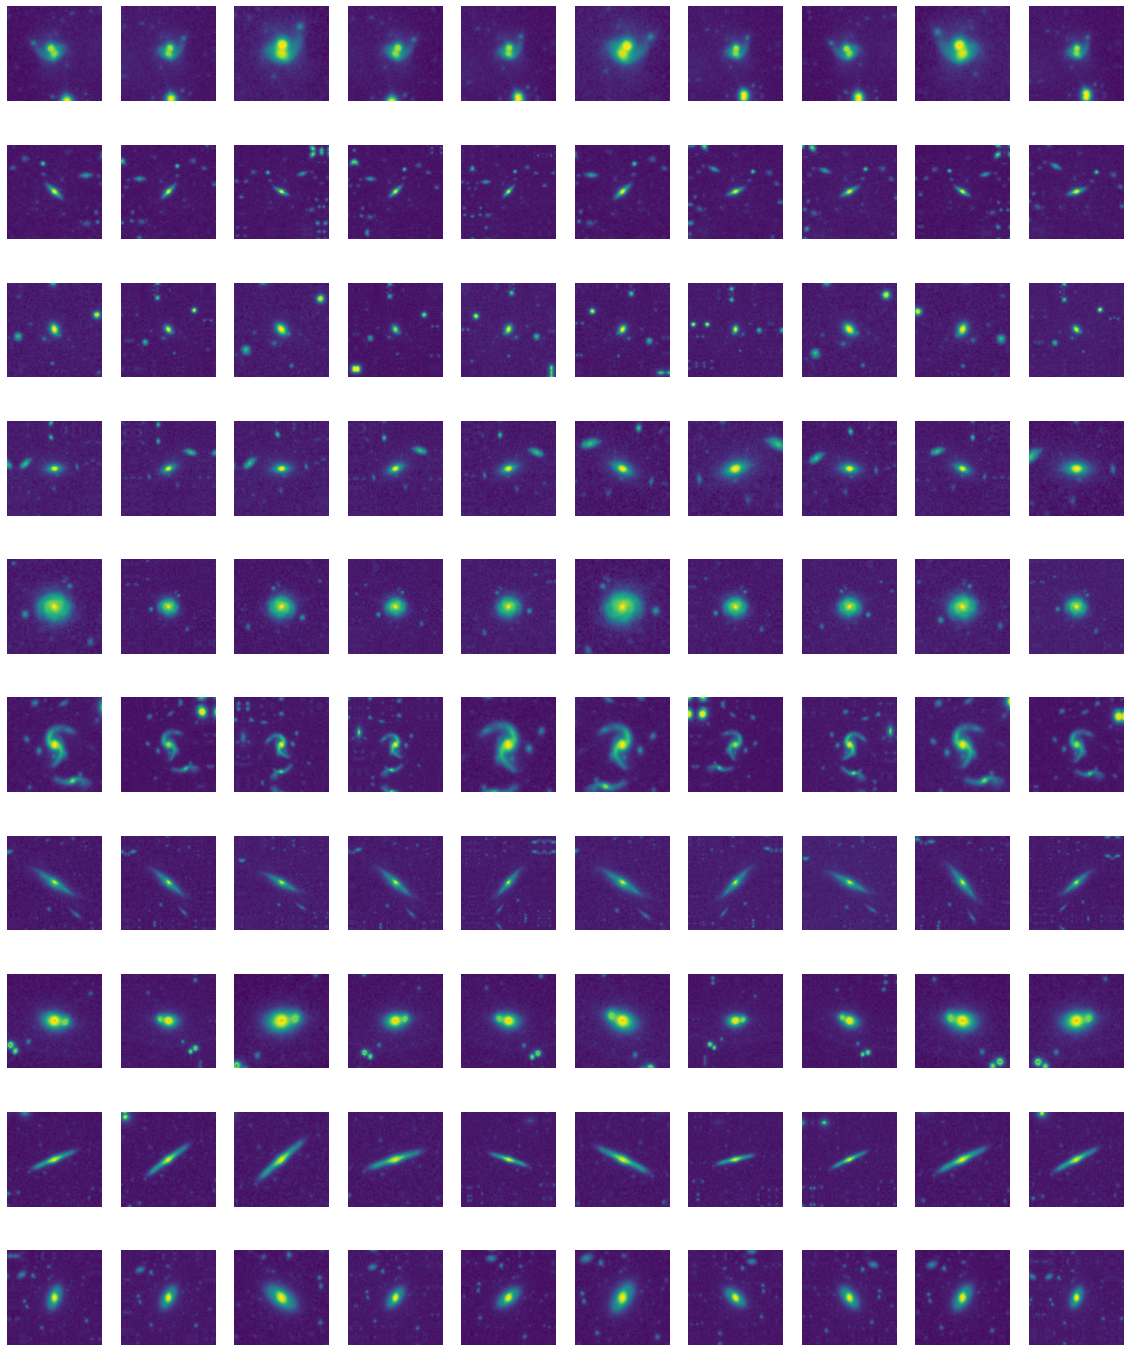

In [51]:
data_augmentation = keras.Sequential([

  # random horizontal flips
  layers.experimental.preprocessing.RandomFlip("horizontal"),

  # randomly Rotate left or right
  layers.experimental.preprocessing.RandomRotation(0.05),

  # random zooms (negative means random zoom ins, positive values are zoom outs)
  layers.experimental.preprocessing.RandomZoom(-0.35),
])


# get 10 images, apply the above augmentations, and see what happens
fig = plt.figure(figsize=[20, 25])
for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(10, 10, i*10 + (j + 1))
        augmented_image = data_augmentation(tf.expand_dims(X_train[i,:,:,:],0), training=True)
        plt.imshow(augmented_image[0])
        plt.axis("off")

From above we can see that there is now a lot more variation in the dataset. Additionally, the random zooms will hopefully lessen the impact of noise. 

**Note**. There seems to be some visual artefacts for some samples (symmetrical dot patterns). I fail to see why this would be due to the augmentation, therefore I would imagine these artifacts may be inherent in the data. 
- A possible explanation could be reflections from the telescope mirrors (telescopes have multiple mirrors that bounce light into a focused beam for the sensor to pick up).

These artefacts will be discussed in the insights section.


Next, I will pass the augmentations through a new model, created from the previous model_cnn_afo model.

In [52]:
# DO NOT RUN

# # load model
# model = loaded_model_cnn_afo

# # removing the input layer
# model.layers.pop(0)

# # creating a new input layer
# input_layer = keras.Input(shape=(128, 128, 1, ), name='img')

# # passing the input through the data augmenter
# augmented = data_augmentation(input_layer)

# # passing the augmented input to the model
# output = model(augmented)

Afterwards, all that is left to do is create a new model using the augmented inputs.

In [53]:
# DO NOT RUN

# model_cnn_afo_aug = keras.Model(inputs=input_layer, outputs=output)
# model_cnn_afo_aug.summary()

Before fitting the model, class imbalances should be accounted for.

### Addressing class imbalance with class weights 

Class weights essentially act as another penalty term. These will make it such that higher class weights places more emphasis on a class. In this context, we want the minority class to be emphasised, and the majority class to be less emphasised.

Now a class_weights variable will be created that will be passed through at fitting time for the upcoming model.

In [54]:
# DO NOT RUN

# from sklearn.utils.class_weight import compute_class_weight

# #store class weights into var
# class_weights = compute_class_weight(
#                                         class_weight = "balanced",
#                                         classes = np.unique(y_train),
#                                         y = y_train                                                    
#                                     )
# class_weights = dict(zip(np.unique(y_train), class_weights))
# class_weights

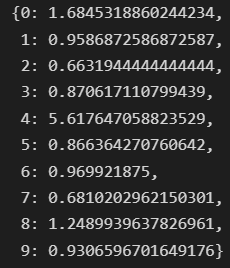

In [55]:
display.Image("Images/class_weights.png")

Note here that the greatest weighting is for class 4 - the class with the least samples (approx. 300) while Class 2 which had the most (approx. 2600 samples) has the smallest weighting.

After addressing the factors that may be hampering performance, it is time once again to test a model.

### The 4th model

As seen previously, the 4th model will be a mirror image of the 3rd in terms of network structure. The differences lie in their input data, class weights, and y_train.
- For this model, the input data will consist of augmented inputs to account for noise
- Class weights were adjusted to account for class imbalance

Now to load the pretrained model.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 128, 128, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 1)       0         
                                                                 
 galaxy_classification_cnn_A  (None, 10)               4758498   
 FO (Functional)                                                 
                                                                 
Total params: 4,758,498
Trainable params: 4,758,002
Non-trainable params: 496
_________________________________________________________________


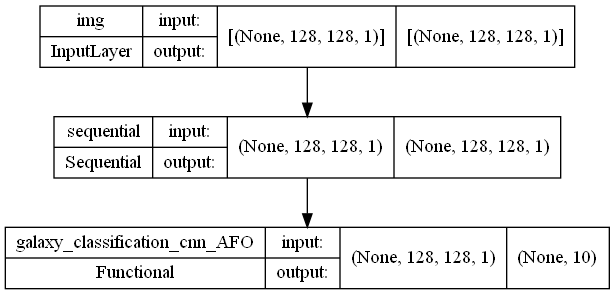

In [56]:
loaded_model_cnn_afo_aug = tf.keras.models.load_model("model_cnn_afo_aug")
loaded_model_cnn_afo_aug.summary()
keras.utils.plot_model(loaded_model_cnn_afo_aug, show_shapes=True)

### Compiling Parameters

These will again remain the same.

In [57]:
# DO NOT RUN

# model_cnn_afo_aug.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
#                   optimizer=keras.optimizers.Adam(),
#                   metrics=['accuracy'])


### Fitting Parameters

Here it will remain the same as the previous model with one exception - class weights will be passed through at model fit.

In [58]:
# DO NOT RUN

# #early stopping params
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# fitting_start = process_time()

# model_cnn_afo_aug_history = model_cnn_afo_aug.fit(X_train, y_train,
#                         batch_size = 128,
#                         epochs=100,
#                         validation_data=(X_val, y_val),
#                         callbacks=early_stopping,
#                         class_weight=class_weights
#                         )

# fitting_end = process_time()

# print('Time to fit data:   %f seconds' % (fitting_end - fitting_start))

For reference, this model took 302.24 seconds to train, reaching the 30th epoch before early stopping.

In [59]:
# evaluate the model 
_, train_acc = loaded_model_cnn_afo_aug.evaluate(X_train, y_train, verbose=1)
_, test_acc = loaded_model_cnn_afo_aug.evaluate(X_test, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

34/34 [==============================] - 0s 4ms/step - loss: 1.2894 - accuracy: 0.6786
Train: 0.712, Test: 0.679


Test accuracy has not really changed a substantial amount from the previous model.

34/34 - 0s - loss: 1.2894 - accuracy: 0.6786 - 137ms/epoch - 4ms/step
Test loss: 1.2893664836883545
Test accuracy: 0.6785714030265808
              precision    recall  f1-score   support

           0       0.43      0.19      0.27        62
           1       0.70      0.69      0.69       112
           2       0.83      0.86      0.85       155
           3       0.86      0.85      0.85       127
           4       0.28      0.89      0.43        28
           5       0.66      0.73      0.69       111
           6       0.62      0.63      0.63       105
           7       0.61      0.51      0.55       170
           8       0.77      0.70      0.73        86
           9       0.72      0.68      0.70       108

    accuracy                           0.68      1064
   macro avg       0.65      0.67      0.64      1064
weighted avg       0.69      0.68      0.68      1064



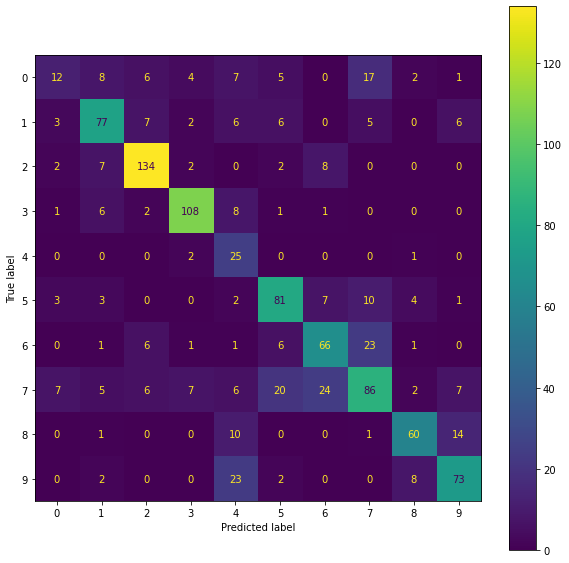

In [60]:
evaluate_model(loaded_model_cnn_afo_aug, X_test, y_test)

### Classification Report Analysis

From the classification report we can discern that:

1. class 0 and class 4 continue to struggle being correctly classified, having the lowest F1 scores
2. class 2, 7, 3 are doing well in terms of being correctly classified.

class 0 
- 43% of all positively predicted classifications were truly positive (precision)
- 19% of all ground truth positives were correctly classified as class 0 (recall)

class 4
- 28% of all positively predicted classifications were truly positive (precision)
- 89% of all ground truth positives were correctly classified as class 4 (recall)

class 2
- 83% of all positively predicted classifications were truly positive (precision)
- 86% of all ground truth positives were correctly classified as class 2 (recall)

class 3
- 86% of all positively predicted classifications were truly positive (precision)
- 85% of all ground truth positives were correctly classified as class 3 (recall)

Overall F1 scores have not increased significantly (macro average at .64)

### Confusion Matrix Analysis

From the confusion matrix we can discern that:

1. Class 0 and 4 have the least correct classifications, with class 0 having the least.
2. Class 2, 7, and 3 have the most correct classifications.

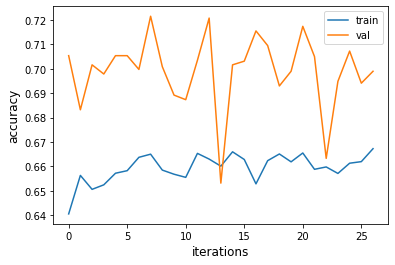

In [61]:
display.Image("Images/cnn_afo_aug_hist_acc.png")

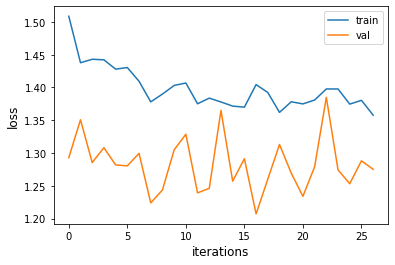

In [62]:
display.Image("Images/cnn_afo_aug_hist_loss.png")

The above graphs suggests that learning was definitely more volatile for this model. It may be due to to data augmentation and learning rate.

### Evaluation Summary

It would seem that data augmentation and accounting for the class imbalance with class weights has not really improved the model.

There could be a few reasons for this:

1. **Network architecture and layer parameters**. Again, the structure of the layers might be suboptimal for this classification task.
- Perhaps with data augmentation, a deeper CNN is needed with greater layer parameters.
- The networks used here are simple, feed-forward NNs. Perhaps Siamese Networks, auto-encoders, multi-task learning techniques could be used
- Fine tuning an existing, estabished neural network could drastically improve performance (see <a href= "https://keras.io/api/applications/">here </a> for a list of established models)
2. **Learning rate**. Perhaps adjusting the learning rate may positively affect performance.
- Data augmentation may be causing the volatile accuracies and losses seen in their respective graphs. 
3. **Class imbalance not fully addressed**. Although class weights were used to address the class imbalance, perhaps the fact that there is so little data for the minority classes may have made the addition of class weights negligible.
- A better alternative could be oversampling the minority class (using a technique like SMOTE), to see if performance would increase
- Note however that I would not expect the performance increase to be significant, as using class weights is essentially a way of implementing oversampling implicitly.
- The class imbalance would also explain why class 0 has low precision yet high recall.
 

4. **Dataset noise**. Although I attempted to account for pixel noise by using data augmentation, it may not have fully alleviated the problem. 
- The problem itself is likely to be inherent with the image data, i.e. the dataset itself could be an issue.
    - Fuzziness and blur due to out of focus images, atmospheric disturbances etc., varying photo quality (some images are good quality, some images are bad quality).


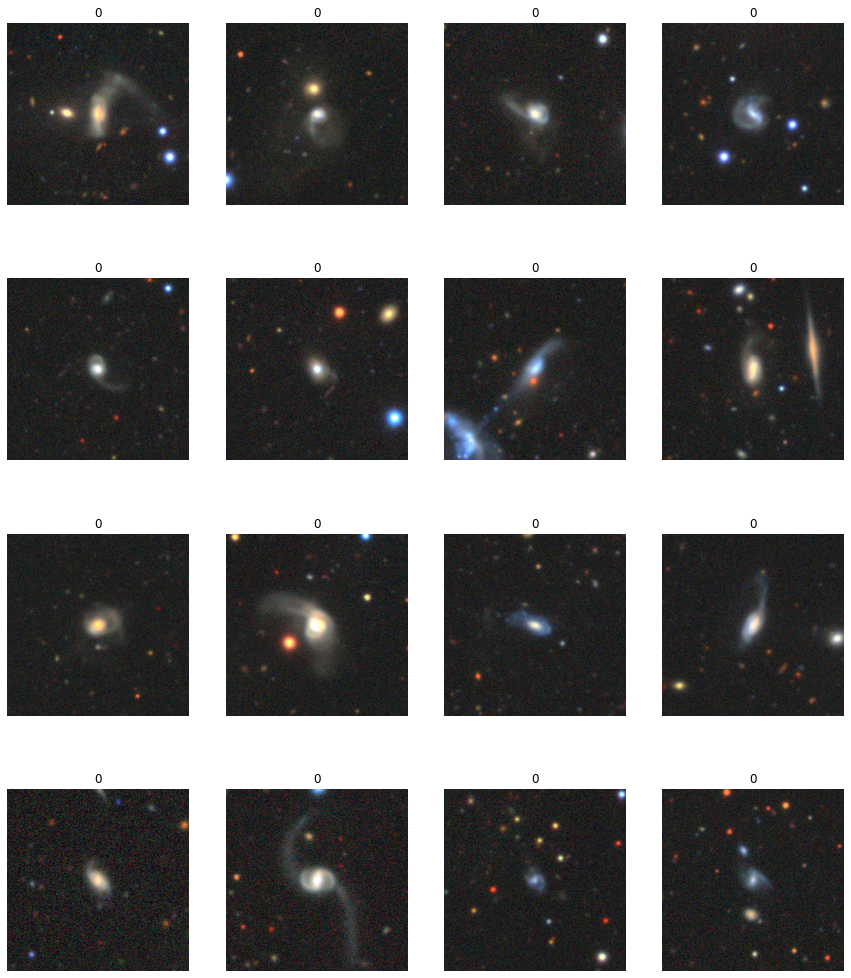

In [63]:
display.Image("Images/original_dataset_plot_image_output.png")

### 5. Ground truth classes

Perhaps the reason that class 0 and 4 have barely any correct classifications is due to the nature of the class itself. From above we can see images classified as  0 (disturbed). At face value, These images could be vaguely grouped by their long, wispy galactic tails. However, visual inspection would lead me to believe that if I myself were to classify these, I would not group the top-left-most image with the top-right-most image. This is just one example, I'm sure space agency stakeholders would also agree that the class 0 images above would be very hard to place in the same group visually. I would argue that the same would apply for class 2 images as well.

Perhaps the model's difficulty in classifying the minority classes is not due to anything involved in the analyses implemented, but rather are due to the ground truth of these classes being hard to classify in the first place, even by human visual inspection.


For the purposes of this project I will let the analysis end here. The above factors could be considered for another model however this notebook will become too large otherwise. Future improvements will be further expanded upon in the insights section.

# 1.5 Insight

### Overall Analysis Summary

The above analysis was conducted in order to prototype a model that can adequately classify galaxies within 10 prescribed classes. From this problem statement, below is a brief summary of the prototyping models implemented to address said problem:

1. model_nn
- Consisted of an input, dense layers, and an output.
- This performed poorly. The network was not deep enough to adequately extract the abstractions needed to classify the galaxies.
2. model_cnn
- Consisted of an input, convolutional layers, MaxPool layers, and an output
- This model performed better than the first, However it was prone to overfitting.
3. model_cnn_afo
- Included convolutional layers with regularisation, spatial dropout and dropout layers, batchnorm layers to account for overfitting
- Performed well at around 70% accuracy and 64% macro average. Still struggled to classify minority classes due to class imbalance.
4. model_cnn_afo_aug
- Data augmented to improve generalisability, class weights implemented to account for class imbalance. Used the same architecture as model 3.
- Performed roughly the same as the previous model.

## **What insights can be gained from these prototypes?**

### Insights about Neural Networks

From the analyses conducted, hopefully a few characteristics of Neural Networks should be clear. They are:

1. **Extremely difficult to tune**. 
- It is hard to know what exact parameters to use to achieve the best results.
- We can combat over and underfitting with established techniques, however feature extraction is definitely a trial and error process.
2. **Computationally, financially, and temporally expensive**.
- The network architectures used within this analysis could be considered rather simple compared to the more complex models seen in scientific literature. 
- This was on purpose as otherwise model training, testing and evaluation would take considerably longer, as well as requiring much better and more expensive computational hardware.
- The fact that model training had to be outside the notebook should be enough evidence for the computational requirements of NNs.
3. **Data quality and data pre-processing may be the most important step for analysis**.
- What if data wasn't converted to grayscale or resized to have less pixels? What if data wasn't normalised? What if train test split distributions were different?
    - These are just some of the pre-processing considerations that could have affected model performance. Along with the neural network parameters/architecture, these factors make NNs extremely variable in performance.
4. **Having a clear ground truth is important**.
- If ground truth data is not of the highest quality and the ground truth classes are difficult to classify to begin with, then networks should not be expected to perform well under these circumstances.

### Insights about Galaxy Classification

1. **Even for humans, classification is difficult.**
- Visual inspection of the minority classes would lead me to believe that I would not be able to classify the majority of class 0 images correctly. They are simply too varied, even if they do share similar traits.
2. **Bound to have class imbalances, due to ground truth**
- Chances are, there are not an equal amount of galaxies that belong in the 10 classes in the universe. Data distribution and model performance reflect this ground truth.
3. **Ground truth classes may be suboptimal**.
- Perhaps there is a better way of classifying these galaxies such that the ambiguity for the minority classes like class 0 could be addressed. Of course I am saying this with little background knowledge on the process of classifying these galaxies. This is purely based on my visual inspection of minority class data.
4. **Data quality varies**. The images from the data used were taken from an on-ground telescope. These are extremely susceptible to noise as they do not simply take a quick photo of a galaxy, but rather are taking exposures and following the galaxy as the Earth rotates. 
- As the telescope does this, a small cloud passing by, humidity on the lens, and other factors, will be enough to contribute to suboptimal image quality.
- As such, the data will be much more susceptible to noise and corruption compared to other domains such as face recognition where quick face shots are easy enough to get.
- This could be resolved by using data from space telescopes (i.e. Hubble, JWST) however the accessibility and the sheer size of this data (much greater than 128x128 or 256x256 pixels) would be a definite problem.

### Who can benefit from these insights?

1. **The space agency**.
- Perhaps the space agency may reconsider implementing neural network models for classification after this analysis as acquiring greater performance may take more computational, temporal, and financial resources than they have the budget for.
    - This is especially important when considering that free alternatives already exist (crowd-sourcing)
    - An alternative consideration would be to spend resources to nurture and cultivate the crowd-sourcing effort for the betterment of science.
- On the other hand, if budget and data accessibility is not an issue, then the creation of deep, convolutional neural networks using Hubble or JWST image data could provide a highly accurate model for galaxy classification.
2. **The scientific community**.
- This analysis should hopefully highlight the impact of both data quality and data pre-processing on neural network model performance. While high quality image data is easier to collect in other domains, perhaps those interested in galaxy classification should first critique the quality of their data to ensure that the analysis pipeline goes smoothly and with less hassle.
    - An additional pre-processing step could be the exclusion of images that does not meet a certain quality metric, even if it is for a sparse class.
- Another factor that the scientific community could consider is the definition of the ground truth classes. The fact that the disturbed galaxy class had such varied galaxies (with the only shared characteristic being wispy tails) would lead me to believe that perhaps these ground truth classes may not be the best (at least, for the minority classes). 
    - If these classes remained as they are, the use of other types of data alongside image data could prove useful for classification of minority classes (multi-input neural networks).
- The scientific community could also critique the network architecture used. The best way to do this would be to fine tune an established, well performing dataset and see if it can score greater in accuracy and precision-recall metrics.
    - VGG16, ResNet50, MobileNetV2 are just some examples of pretrained models built-in to <a href= "https://keras.io/api/applications/" >keras</a>
    - It is highly likely that the architectures used are not optimal. Parameters could also be tuned with grid search.
    - An example of a better performing model can be found <a href= "https://codebox.net/pages/neural-network-for-galaxy-classification" >here</a>. 
        - Note that the author is doing a 3-class galaxy classification, but nonetheless has achieved around 96% accuracy. Class imbalance may be less pronounced in this case.
            - Additionally, it took them an hour of training time to achieve this!
3. **Crowdsourcing stakeholders**.
- The results of this analysis may be reassuring to those that volunteer for crowd-sourced galaxy classification projects. Unless stakeholders have the funds to generate deep, complex models with the high quality of data needed, crowd-sourcing will continue to be the best method for galaxy classification, due to the much greater classification capabilities of the human brain, multiplied by the amount of human brains that have volunteered.
- At the same time however, as more and more of our universe is captured through our telescopes, the worrying increase in data may prove too much even for the current crowd-sourced international effort. with astronomical data becoming 'astronomical' in size, there will probably come a point in time when crowd-sourcing is simply unfeasible for big data. Crowd-sourcing stakeholders should definitely consider this moving forward.
    - Neural networks may be expensive and time-consuming, but they have the amazing capacity of performing better and better as they are fed more and more data. Crowd-sourcing efforts unfortunately might not work the same way.
        - NNs have linear increase in training time as dataset size increases, no increase in testing time as dataset size increases, with test set accuracy improving as dataset size increases.
    

### Ethical Considerations

#### Accuracy as a performance measure for imbalanced classes

It is important to bring up some ethical considerations with regards to the results of this analysis. 

The main point being the correct usage of performance metrics when there are imbalanced classes.
- In this analysis, accuracy was used as a general performance metric, however true performance was analysed using other metrics such as precision, recall, F1, and macro averages.
- In this sense, it is important to stress that accuracy should **NOT** be used as the main performance metric when there are imbalanced classes.
    - e.g. If classes are significantly imbalanced, great accuracy is easy to achieve as the network would just classify the majority of samples as the majority class (like what we saw with class 2). 
    - Accuracy in this context does not tell us anything about the true positives, false positives, true negatives, and false negatives
    - It also does not tell us about classification performance for each class (e.g. the fact that class 0 and 4 were being poorly classified)
        - precision-recall metrics keep these in consideration.
        
While this may not be as impactful within the current domain (galaxy classification), the misinterpretation of performance metrics may have disastrous ethical implications in others (biomedical applications like tumor, stroke, Alzheimer's  classification for example).
- The use of accuracy when there are imbalances may create networks in these domains that accurately classify majority classes but not minority classes.
    - As such, minority classes, which could be severe or terminal, could be incorrectly classified as not being as mentioned due to the bias towards majority classes.

In the general domain of science, this should also be considered.
- The publish or perish aphorism could lead young and highly driven scientists to publish results with high accuracy at the forefront, completely excluding precision-recall metrics in order to hide the limitations of their model.
    - Honesty and integrity can therefore be compromised in favour of personal and professional gain.




#### Has online/crowd-sourced data been subject to proper scrutiny?


While projects such as the Galaxy Zoo project and Galaxy10 seem to be run by established astronomers from the international scientific community, the same can't be said for other smaller crowd-sourced projects.
As such, it is always important to consider the source of data and analyses before using them for your own.

The validity of the data and in turn your analysis will be dependent upon the way the data was collected
- Using data from a random person on the internet will definitely threaten analysis validity
    - Where did they get the data from?
    - How did they collect the data?
    - Is the dataset labelled properly?
    - What were the criterion for the labels?

An extremely hypothetical example of this would be if someone posted face recognition online, yet only had images of their face within it. A young, budding data scientist/analyst may end up using this data without looking through the documentation (if there even is any) and run models using this dataset.
- This would threaten analysis validity as the data scientist/analyst's focal question may involve baby face recognition using baby face data, yet the data used for training is of an adult's face (and only 1 adult to be precise).

It is therefore up to the young and budding data scientist/analyst to scrutinise the dataset that they will use for their analyses. 

Additionally, The Galaxy10 dataset calls into question whether data of varying image quality should be used for scientific analysis in the first place.
- Too many confounding noise variables could draw into question the validity of the classification models 
    - Did my neural network really train on the galaxies pictures? Or did it train on the noise or the artefacts (symmetrical dot patterns) surrounding it?
    - Perhaps it would be better to have a quality metric to judge images at a sufficient level.

This leads to another ethical consideration, which is the black box of neural networks.

#### Neural Network black box

How did my neural network models classify galaxies? 

- I know that they used the training set to learn patterns
- I know that they extracted features from each image to learn on
- I know that it was able to predict classes based on what it has learned
- But what are these features exactly? Were they, like me, looking at the wispy tail features for class 0? Or were they training on a higher level abstraction that is completely undecipherable to humans (random patterns in noise for example)?

Such is the nature of neural networks. We know they work, we know they work well. However the underlying mechanisms that they use to work well are still a 'black box'.





LIME in this context could have been implemented, however I was unable to implement it for the case of this analysis. I can however speculate that the performance for the minority classes may be due to not only the lack of data and the nature of the classes as aforementioned, but also the amount of pixel noise within the images.
- This would have negatively affected training for all classes, but especially for the minority classes that lacked data in the first place.
- For class 0, the vagueness of the ground truth, alongside the noise and presence of artefacts with patterns, would have made it very difficult to classify.
- On the other hand, the classification of class 2 may not just be from bias due to class imbalance, but also bias generated from within the image dataset itself.
    - there could be random patterns in the noise of the image data.
    - A hypothetical yet completely plausible example of this would be dead pixels.
        - As the cameras take exposures, the sensor becomes hotter and hotter, making dead pixels an inevitability even with proper cooling.
        - These dead pixels would appear on multiple images, assuming that the same camera was used to take all images.
        - Class 2 might therefore be classified based on the dead pixel patterns, which may not have existed when the other class images were taken (again, purely hypothetical to explain the point).

As such, it would be of great ethical importance to be able to explain what neural networks are doing from within, as again, the validity of the analysis is threatened when these are not made clear.
- The goal was to classify galaxies based on their shape features (which is why the image was converted to grayscale). If it's learning on dead pixel patterns, this threatens internal validity.
- If the neural network is learning on features other than shape, perhaps converting back to the 3 channels may prove beneficial, but then the focal question will have to be changed to accommodate.



        

### Considerations for Future Improvement

There are simply too many ways to improve or change the current analysis. Below I will briefly list the improvements that have been mentioned across the entire notebook.

**Data and preprocessing**
1. Remove low quality image data
2. Keep 256x256x3 dimensions (will need better hardware)
3. Don't normalise training set
4. Use a different dataset and different ground truth classes altogether (<a href ="https://astronn.readthedocs.io/en/latest/galaxy10sdss.html">Galaxy10 SDSS for example</a>)
    
**Network architecture**
1. Add more convolutional and fully connected blocks (10 stage if courageous)
2. Try a siamese network (contrastive or triplet loss)
3. Try multi-output NN (multi-task learning, have a regression output as well as classification output)
4. Try multi-input NN
5. Try fine-tuning existing models

**Network Parameters**
1. Try decrementing filter amount instead of incrementing
2. Try a significantly larger filter amount for the first convolutional block (e.g. 64 instead of 8)
3. Add more fully connected layers before the output layer (3-5 instead of 2)
4. try 1x1 convolutional filter size
4. Implement a grid search that can optimise these parameters

**Compiling parameters**
1. Try adjusting learning rate
2. Try a different optimiser (Nadam, SGD, RMSprop)
3. Use a different performance metric at compilation (SparseCategoricalAccuracy)

**Fitting Parameters**
1. Experiment with batch size
2. Experiment with number of epochs
3. Experiment with steps per epoch
4. Implement a grid search that can optimise these parameters


**Comparison with other machine learning models**
1. Train an SVM and compare performance
2. Perform clustering(K-Means) and compare performance


**Implement LIME for explainability**
1. Is learning due to shape features or noise or some higher level abstractions?